# Monthly Return of 60/40 Portfolio

In [ ]:
from Config import *
import pandas as pd
import numpy as np
import quantstats as qs
qs.extend_pandas()

BONDS_TICKER = 'LUATTRUU'
STOCK_TICKER = 'SPTX'

if __name__ == '__main__':
    bond_df = pd.read_csv(os.path.join(os.path.join(DATA_DIR, 'stock'), f'{BONDS_TICKER}.csv'), parse_dates=['Date'])
    stock_df = pd.read_csv(os.path.join(os.path.join(DATA_DIR, 'stock'), f'{STOCK_TICKER}.csv'), parse_dates=['Date'])

    bond_df.sort_values('Date', inplace=True)
    stock_df.sort_values('Date', inplace=True)
    #
    df = pd.merge(bond_df, stock_df, on='Date', how='inner', suffixes=('_bond', '_stock'))
    df = df[['Date', 'Close_bond', 'Close_stock']]
    df.columns = ['Date', 'Bond', 'Stock']
    for col in ['Bond', 'Stock']:
        df[col+'_pctchange'] = df[col].pct_change()
        df[col+'_pctchange'] = df[col+'_pctchange'].fillna(0)
        df[col+'_pnl'] = (1+df[col+'_pctchange']).cumprod()

    # classic 60/40 portfolio, No transaction cost
    df['ports_pctchange'] = 0.6*df['Bond_pctchange'] + 0.4*df['Stock_pctchange']
    df['ports_pnl'] = (1+df['ports_pctchange']).cumprod()

    df.set_index('Date', inplace=True)

    # Convert daily pnl to monthly returns
    monthly_returns = df['ports_pnl'].resample('M').last().pct_change().fillna(0)

    # Save or display monthly returns
    print(monthly_returns)
    monthly_returns.to_csv('monthly_returns_6040.csv')


Date
1994-04-30    0.000000
1994-05-31    0.005834
1994-06-30   -0.011159
1994-07-31    0.024062
1994-08-31    0.016390
                ...   
2024-06-30    0.020375
2024-07-31    0.018173
2024-08-31    0.017888
2024-09-30    0.015973
2024-10-31   -0.010212
Freq: ME, Name: ports_pnl, Length: 367, dtype: float64


# New Strategy

In [ ]:
import pandas as pd
import numpy as np

def generate_signal(price_series, short1, long1, short2, long2):
    """
    Generates a trading signal based on two EMA crossover strategies for going long on XAU.
    """
    df = pd.DataFrame(price_series)

    # Calculate EMAs for both strategies
    df['long_ma1'] = price_series.ewm(span=long1, adjust=False).mean()
    df['short_ma1'] = price_series.ewm(span=short1, adjust=False).mean()
    df['long_ma2'] = price_series.ewm(span=long2, adjust=False).mean()
    df['short_ma2'] = price_series.ewm(span=short2, adjust=False).mean()

    # Generate signals: 1 if both signals are active, 0.5 if one is active, and 0 if neither
    df['signal'] = np.where((df['short_ma1'] > df['long_ma1']) & (df['short_ma2'] > df['long_ma2']), 1,
                            np.where(df['short_ma1'] != df['long_ma1'], 0.5, 0))

    return df[['signal']]

def calculate_position_returns(signal_df, returns_series):
    """
    Calculates returns based on signals, with a one-day delay.
    """
    # Shift signal by one day for trading implementation
    signal_df['shifted_signal'] = signal_df['signal'].shift(1)
    signal_df['position_returns'] = returns_series * signal_df['shifted_signal']

    return signal_df[['shifted_signal', 'position_returns']]


In [ ]:
# Load 60/40 portfolio returns (assuming you already have monthly_returns_6040 calculated)
monthly_returns_6040 = pd.read_csv('monthly_returns_6040.csv', index_col='Date', parse_dates=True)

# Load gold returns (or any other data that the leveraged strategy depends on)
data = pd.read_excel('equity_bond_gold.xlsx', sheet_name='equity_bond_gold_price', parse_dates=['Dates'])
data.rename(columns={'XAU Curncy': 'Gold'}, inplace=True)
data = data[data['Dates'] >= '1994-03-01']
data.set_index('Dates', inplace=True)

# Calculate monthly returns for Gold
data['Gold_pctchange'] = data['Gold'].pct_change().fillna(0)
monthly_returns_gold = data['Gold_pctchange'].resample('M').apply(lambda x: (1 + x).prod() - 1)

# Define the leveraged strategy: 100% 60/40 portfolio + 10% Gold
leveraged_strategy_returns = monthly_returns_6040['ports_pnl'] + 0.1 * monthly_returns_gold

# Save or display the leveraged strategy monthly returns
print("Monthly Returns for Leveraged Strategy:")
print(leveraged_strategy_returns)
leveraged_strategy_returns.to_csv('monthly_returns_leveraged_strategy.csv')


Monthly Returns for Leveraged Strategy:
1994-03-31         NaN
1994-04-30   -0.003568
1994-05-31    0.008552
1994-06-30   -0.011417
1994-07-31    0.023364
                ...   
2024-07-31    0.023367
2024-08-31    0.020168
2024-09-30    0.021214
2024-10-31   -0.006060
2024-11-30         NaN
Length: 369, dtype: float64


In [ ]:
# Load the data if not already loaded
monthly_returns_leveraged = pd.read_csv('monthly_returns_leveraged_strategy.csv')

# Drop the first and last data points
monthly_returns_leveraged = monthly_returns_leveraged.iloc[1:-1]

# Save the cleaned data back to CSV if needed
monthly_returns_leveraged.to_csv('monthly_returns_leveraged_cleaned.csv')

# Display the cleaned DataFrame
print(monthly_returns_leveraged)


     Unnamed: 0         0
1    1994-04-30 -0.003568
2    1994-05-31  0.008552
3    1994-06-30 -0.011417
4    1994-07-31  0.023364
5    1994-08-31  0.017172
..          ...       ...
363  2024-06-30  0.020350
364  2024-07-31  0.023367
365  2024-08-31  0.020168
366  2024-09-30  0.021214
367  2024-10-31 -0.006060

[367 rows x 2 columns]


In [ ]:
# Load the CSV without parsing dates initially
monthly_returns_6040 = pd.read_csv('monthly_returns_6040.csv')
print(monthly_returns_6040.head())

# Check the columns to confirm the column names and types
print(monthly_returns_6040.columns)


         Date  ports_pnl
0  1994-04-30   0.000000
1  1994-05-31   0.005834
2  1994-06-30  -0.011159
3  1994-07-31   0.024062
4  1994-08-31   0.016390
Index(['Date', 'ports_pnl'], dtype='object')


# Mixed Strategy

In [ ]:
# Load the leveraged strategy file without setting index_col initially
monthly_returns_leveraged_strategy = pd.read_csv('monthly_returns_leveraged_strategy.csv')
# Rename columns
monthly_returns_leveraged_strategy.columns = ['Date', 'Return']

# Drop the first row
monthly_returns_leveraged_strategy = monthly_returns_leveraged_strategy.iloc[1:]
monthly_returns_leveraged_strategy

,Date,Return
1,1994-04-30,-0.003568
2,1994-05-31,0.008552
3,1994-06-30,-0.011417
4,1994-07-31,0.023364
5,1994-08-31,0.017172
...,...,...
364,2024-07-31,0.023367
365,2024-08-31,0.020168
366,2024-09-30,0.021214
367,2024-10-31,-0.006060


## Compare Performance

In [ ]:
def calculate_metrics(returns, annualization_factor=12):
    cumulative_return = (1 + returns).prod() - 1
    years = len(returns) / annualization_factor
    cagr = (1 + cumulative_return) ** (1 / years) - 1
    annualized_volatility = returns.std() * np.sqrt(annualization_factor)
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()
    sharpe_ratio = cagr / annualized_volatility
    downside_returns = returns[returns < 0]
    annualized_downside_deviation = downside_returns.std() * np.sqrt(annualization_factor)
    sortino_ratio = cagr / annualized_downside_deviation
    positive_excess_returns = returns[returns > 0].sum()
    negative_excess_returns = abs(returns[returns < 0].sum())
    omega_ratio = positive_excess_returns / negative_excess_returns
    calmar_ratio = cagr / abs(max_drawdown)

    return pd.Series({
        'CAGR': cagr,
        'Annualized Volatility': annualized_volatility,
        'Max Drawdown': max_drawdown,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Omega Ratio': omega_ratio,
        'Calmar Ratio': calmar_ratio
    })


In [ ]:
alpha = 0.9
# Calculate the mixed strategy returns
monthly_returns_mixed = alpha * monthly_returns_6040['ports_pnl'] + (1 - alpha) * monthly_returns_leveraged_strategy['Return']
monthly_returns_mixed_08 = 0.8 * monthly_returns_6040['ports_pnl'] + (1 - 0.8) * monthly_returns_leveraged_strategy['Return']
monthly_returns_mixed_07 = 0.7 * monthly_returns_6040['ports_pnl'] + (1 - 0.7) * monthly_returns_leveraged_strategy['Return']
monthly_returns_mixed_06 = 0.6 * monthly_returns_6040['ports_pnl'] + (1 - 0.6) * monthly_returns_leveraged_strategy['Return']
monthly_returns_mixed_05 = 0.5 * monthly_returns_6040['ports_pnl'] + (1 - 0.5) * monthly_returns_leveraged_strategy['Return']

# Now calculate metrics for each strategy
metrics_6040 = calculate_metrics(monthly_returns_6040['ports_pnl'])
metrics_leveraged_strategy = calculate_metrics(monthly_returns_leveraged_strategy['Return'])
metrics_mixed_strategy = calculate_metrics(monthly_returns_mixed)
metrics_mixed_strategy_08 = calculate_metrics(monthly_returns_mixed_08)
metrics_mixed_strategy_07 = calculate_metrics(monthly_returns_mixed_07)
metrics_mixed_strategy_06 = calculate_metrics(monthly_returns_mixed_06)
metrics_mixed_strategy_05 = calculate_metrics(monthly_returns_mixed_05)

# Combine metrics into a single DataFrame
metrics_df = pd.DataFrame({
    '60/40 Portfolio': metrics_6040,
    'Leveraged Strategy': metrics_leveraged_strategy,
    'Mixed Strategy 0.9': metrics_mixed_strategy,
    'Mixed Strategy 0.8': metrics_mixed_strategy_08,
    'Mixed Strategy 0.7': metrics_mixed_strategy_07,
    'Mixed Strategy 0.6': metrics_mixed_strategy_06,
    'Mixed Strategy 0.5': metrics_mixed_strategy_05
})

# Display and save the metrics table
metrics_df


,60/40 Portfolio,Leveraged Strategy,Mixed Strategy 0.9,Mixed Strategy 0.8,Mixed Strategy 0.7,Mixed Strategy 0.6,Mixed Strategy 0.5
CAGR,0.072789,0.080361,0.073613,0.074750,0.075790,0.076734,0.077581
Annualized Volatility,0.063804,0.067956,0.057483,0.052081,0.048013,0.045637,0.045220
Max Drawdown,-0.171308,-0.179226,-0.164521,-0.157882,-0.152699,-0.153578,-0.154722
Sharpe Ratio,1.140835,1.182541,1.280599,1.435246,1.578524,1.681401,1.715635
Sortino Ratio,1.627262,1.677518,1.803154,1.997965,2.150182,2.229411,2.278010
Omega Ratio,2.309507,2.379930,2.536198,2.804916,3.113554,3.406178,3.560972
Calmar Ratio,0.424903,0.448376,0.447439,0.473451,0.496338,0.499644,0.501424


In [ ]:
def calculate_rolling_metrics(returns, window=12):
    """
    Calculate rolling metrics: volatility, Sharpe ratio, and max drawdown.

    Parameters:
    - returns: pd.Series of monthly returns.
    - window: int, rolling window size in months.

    Returns:
    - pd.DataFrame with rolling volatility, Sharpe ratio, and max drawdown.
    """
    # Rolling Volatility (annualized)
    rolling_volatility = returns.rolling(window).std() * np.sqrt(12)

    # Rolling Sharpe Ratio (annualized)
    rolling_sharpe = returns.rolling(window).mean() / returns.rolling(window).std() * np.sqrt(12)

    # Rolling Maximum Drawdown
    rolling_drawdown = returns.rolling(window).apply(
        lambda x: (1 + x).cumprod().div((1 + x).cumprod().cummax()).min() - 1,
        raw=False
    )

    # Combine results into a DataFrame
    rolling_metrics_df = pd.DataFrame({
        'Rolling Volatility': rolling_volatility,
        'Rolling Sharpe Ratio': rolling_sharpe,
        'Rolling Max Drawdown': rolling_drawdown
    })

    return rolling_metrics_df


In [ ]:
# Assuming monthly_returns_6040, monthly_returns_new_strategy, and monthly_returns_mixed are loaded as Series
# Apply the function to each strategy
rolling_metrics_6040 = calculate_rolling_metrics(monthly_returns_6040['ports_pnl'])
rolling_metrics_new_strategy = calculate_rolling_metrics(monthly_returns_leveraged_strategy['Return'])
rolling_metrics_mixed = calculate_rolling_metrics(monthly_returns_mixed)


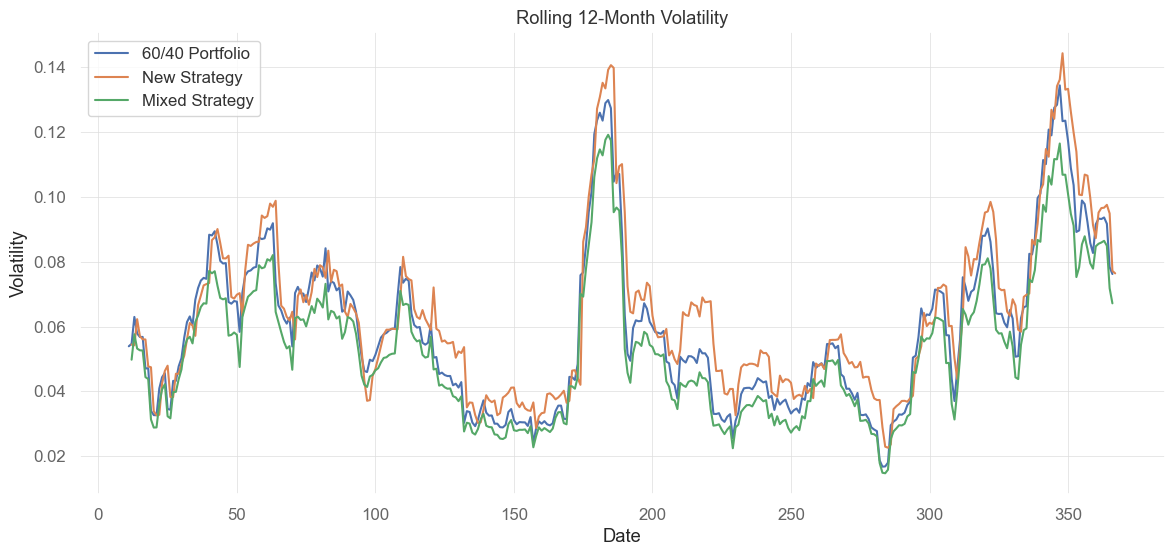

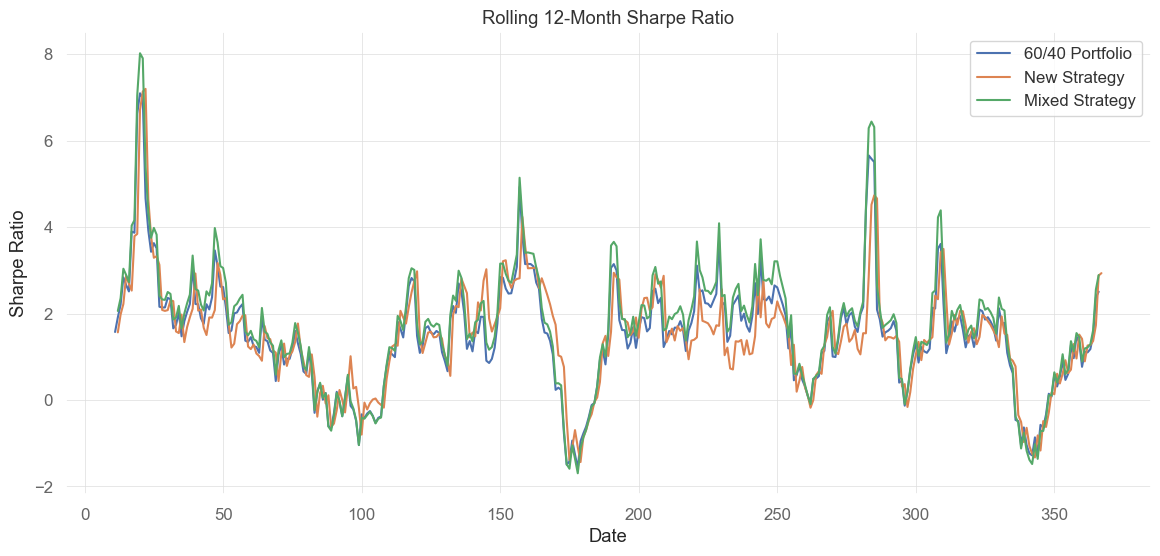

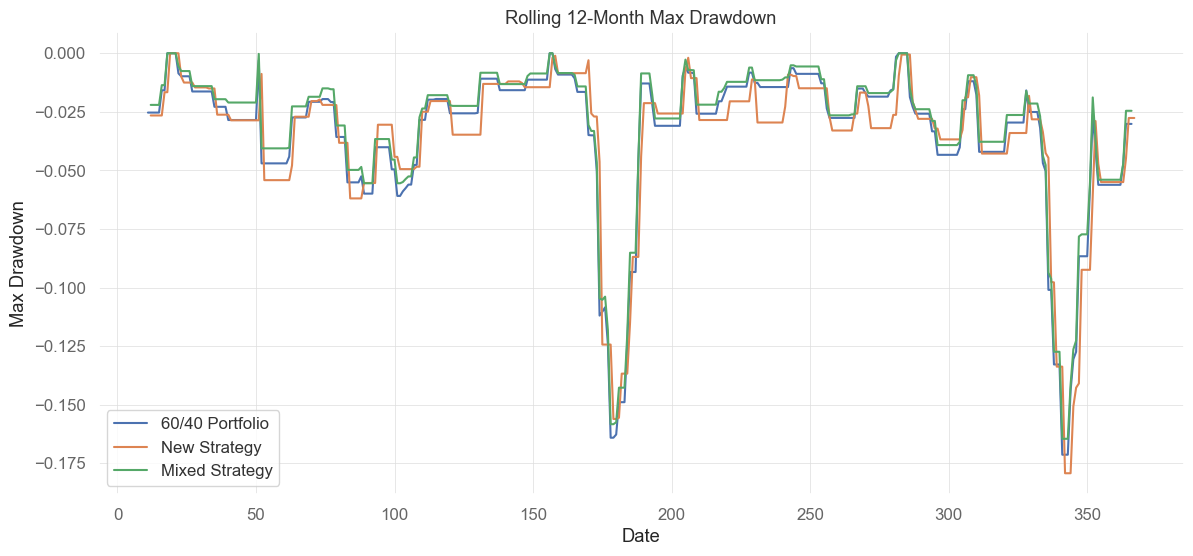

In [ ]:
import matplotlib.pyplot as plt

# Plot rolling volatility
plt.figure(figsize=(14, 6))
plt.plot(rolling_metrics_6040['Rolling Volatility'], label='60/40 Portfolio')
plt.plot(rolling_metrics_new_strategy['Rolling Volatility'], label='New Strategy')
plt.plot(rolling_metrics_mixed['Rolling Volatility'], label='Mixed Strategy')
plt.title('Rolling 12-Month Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# Plot rolling Sharpe ratio
plt.figure(figsize=(14, 6))
plt.plot(rolling_metrics_6040['Rolling Sharpe Ratio'], label='60/40 Portfolio')
plt.plot(rolling_metrics_new_strategy['Rolling Sharpe Ratio'], label='New Strategy')
plt.plot(rolling_metrics_mixed['Rolling Sharpe Ratio'], label='Mixed Strategy')
plt.title('Rolling 12-Month Sharpe Ratio')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.show()

# Plot rolling max drawdown
plt.figure(figsize=(14, 6))
plt.plot(rolling_metrics_6040['Rolling Max Drawdown'], label='60/40 Portfolio')
plt.plot(rolling_metrics_new_strategy['Rolling Max Drawdown'], label='New Strategy')
plt.plot(rolling_metrics_mixed['Rolling Max Drawdown'], label='Mixed Strategy')
plt.title('Rolling 12-Month Max Drawdown')
plt.xlabel('Date')
plt.ylabel('Max Drawdown')
plt.legend()
plt.show()


In [ ]:
def calculate_drawdowns(returns):
    """
    Calculate drawdown and recovery time for a given series of returns.

    Parameters:
    - returns: pd.Series of cumulative returns.

    Returns:
    - drawdown_df: pd.DataFrame with drawdown, recovery time, duration, and depth for each drawdown period.
    """
    # Calculate the cumulative returns
    cumulative_returns = (1 + returns).cumprod()
    peak = cumulative_returns.cummax()

    # Calculate drawdown as the percentage below the peak
    drawdown = (cumulative_returns - peak) / peak

    # Identify drawdown periods
    in_drawdown = drawdown < 0
    drawdown_periods = []
    start_date, end_date = None, None

    for date, is_in_drawdown in in_drawdown.items():
        if is_in_drawdown:
            if start_date is None:
                start_date = date
            end_date = date
        elif start_date is not None:
            # We have exited a drawdown period, record it
            duration = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
            depth = drawdown[start_date:end_date].min()
            recovery_start = end_date
            recovery_end = cumulative_returns[recovery_start:].idxmax()
            recovery_time = (pd.to_datetime(recovery_end) - pd.to_datetime(recovery_start)).days
            drawdown_periods.append({
                'Start': start_date,
                'End': end_date,
                'Duration': duration,
                'Depth': depth,
                'Recovery Start': recovery_start,
                'Recovery End': recovery_end,
                'Recovery Time': recovery_time
            })
            start_date, end_date = None, None

    # Create a DataFrame of drawdown periods
    drawdown_df = pd.DataFrame(drawdown_periods)

    return drawdown, drawdown_df


In [ ]:
# Calculate drawdowns and recovery times for each strategy
drawdown_6040, drawdown_df_6040 = calculate_drawdowns(monthly_returns_6040['ports_pnl'])
drawdown_new_strategy, drawdown_df_new_strategy = calculate_drawdowns(monthly_returns_leveraged_strategy['Return'])
drawdown_mixed, drawdown_df_mixed = calculate_drawdowns(monthly_returns_mixed)

In [ ]:
# Define a threshold for significant drawdowns
drawdown_threshold = -0.10  # 10%

# Filter drawdowns exceeding the threshold
significant_drawdowns_6040 = drawdown_df_6040[drawdown_df_6040['Depth'] < drawdown_threshold]
significant_drawdowns_new_strategy = drawdown_df_new_strategy[drawdown_df_new_strategy['Depth'] < drawdown_threshold]
significant_drawdowns_mixed = drawdown_df_mixed[drawdown_df_mixed['Depth'] < drawdown_threshold]

print("\nSignificant Drawdowns (>10%) for 60/40 Portfolio:")
print(significant_drawdowns_6040)

print("\nSignificant Drawdowns (>10%) for New Strategy:")
print(significant_drawdowns_new_strategy)

print("\nSignificant Drawdowns (>10%) for Mixed Strategy:")
print(significant_drawdowns_mixed)



Significant Drawdowns (>10%) for 60/40 Portfolio:
    Start  End  Duration     Depth  Recovery Start  Recovery End  \
23    164  186         0 -0.167374             186           365   
48    333  358         0 -0.171308             358           365   

    Recovery Time  
23              0  
48              0  

Significant Drawdowns (>10%) for New Strategy:
    Start  End  Duration     Depth  Recovery Start  Recovery End  \
24    170  185         0 -0.156057             185         366.0   
53    334  359         0 -0.179226             359         366.0   

    Recovery Time  
24            0.0  
53            0.0  

Significant Drawdowns (>10%) for Mixed Strategy:
    Start  End  Duration     Depth  Recovery Start  Recovery End  \
21    164  186         0 -0.160948             186           365   
44    333  358         0 -0.164521             358           365   

    Recovery Time  
21              0  
44              0  


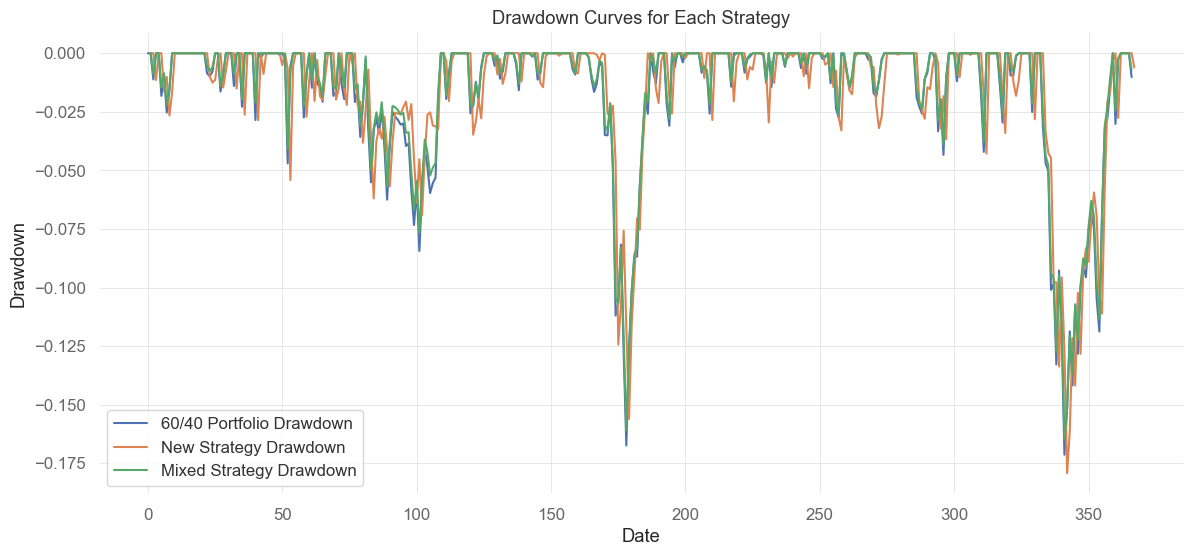

In [ ]:
# Plot drawdown curves
plt.figure(figsize=(14, 6))
plt.plot(drawdown_6040, label='60/40 Portfolio Drawdown')
plt.plot(drawdown_new_strategy, label='New Strategy Drawdown')
plt.plot(drawdown_mixed, label='Mixed Strategy Drawdown')
plt.title('Drawdown Curves for Each Strategy')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.show()


In [ ]:
def calculate_var_cvar(returns, confidence_level=0.95):
    """
    Calculate Value-at-Risk (VaR) and Conditional Value-at-Risk (CVaR) for a given returns series.

    Parameters:
    - returns: pd.Series of returns (e.g., monthly returns).
    - confidence_level: float, the confidence level for VaR and CVaR (e.g., 0.95 for 95%).

    Returns:
    - var: Value-at-Risk at the specified confidence level.
    - cvar: Conditional Value-at-Risk (expected loss beyond the VaR threshold).
    """
    # Calculate the VaR at the specified confidence level
    var = returns.quantile(1 - confidence_level)

    # Calculate the CVaR as the average of losses beyond the VaR threshold
    cvar = returns[returns <= var].mean()

    return var, cvar


In [ ]:
# Calculate VaR and CVaR for each strategy
var_6040, cvar_6040 = calculate_var_cvar(monthly_returns_6040['ports_pnl'])
var_new_strategy, cvar_new_strategy = calculate_var_cvar(monthly_returns_leveraged_strategy['Return'])
var_mixed, cvar_mixed = calculate_var_cvar(monthly_returns_mixed)

# Display the results
print("60/40 Portfolio VaR and CVaR:")
print(f"VaR (95%): {var_6040:.4f}")
print(f"CVaR (95%): {cvar_6040:.4f}")

print("\nNew Strategy VaR and CVaR:")
print(f"VaR (95%): {var_new_strategy:.4f}")
print(f"CVaR (95%): {cvar_new_strategy:.4f}")

print("\nMixed Strategy VaR and CVaR:")
print(f"VaR (95%): {var_mixed:.4f}")
print(f"CVaR (95%): {cvar_mixed:.4f}")


60/40 Portfolio VaR and CVaR:
VaR (95%): -0.0260
CVaR (95%): -0.0373

New Strategy VaR and CVaR:
VaR (95%): -0.0269
CVaR (95%): -0.0390

Mixed Strategy VaR and CVaR:
VaR (95%): -0.0226
CVaR (95%): -0.0332


1. 60/40 Portfolio It represents a traditional, moderate risk profile.

2. New Strategy: Has a slightly higher VaR (-2.69%) and CVaR (-3.90%), indicating a marginally higher risk in extreme cases.

3. Mixed Strategy: Shows the lowest VaR (-2.26%) and CVaR (-3.32%) among the three, suggesting that combining the 60/40 Portfolio with the New Strategy helps reduce both the likelihood and the severity of extreme losses.


In [ ]:
def calculate_tail_risk_measures(returns, threshold=0):
    """
    Calculate tail risk measures for a given returns series.

    Parameters:
    - returns: pd.Series of returns (e.g., monthly returns).
    - threshold: float, the threshold return level for the Omega ratio (e.g., 0 for no loss).

    Returns:
    - pd.Series with skewness, kurtosis, downside deviation, CVaR, and Omega ratio.
    """
    # Skewness: Measures asymmetry
    skewness = returns.skew()

    # Kurtosis: Measures "tailedness" (excess kurtosis; kurtosis - 3 for normal distribution)
    kurtosis = returns.kurtosis()

    # Downside Deviation: Standard deviation of returns below zero (or specified threshold)
    downside_returns = returns[returns < threshold]
    downside_deviation = downside_returns.std() * np.sqrt(12)  # Annualized

    # CVaR: Already calculated in previous step, but we can include it here as well
    var_95 = returns.quantile(0.05)
    cvar_95 = returns[returns <= var_95].mean()

    # Omega Ratio: Ratio of returns above threshold to returns below threshold
    good_returns = returns[returns > threshold].sum()
    bad_returns = abs(downside_returns.sum())
    omega_ratio = good_returns / bad_returns if bad_returns != 0 else np.nan

    return pd.Series({
        'Skewness': skewness,
        'Kurtosis': kurtosis,
        'Downside Deviation': downside_deviation,
        'CVaR (95%)': cvar_95,
        'Omega Ratio': omega_ratio
    })


In [ ]:
# Calculate tail risk measures for each strategy
tail_risk_6040 = calculate_tail_risk_measures(monthly_returns_6040['ports_pnl'])
tail_risk_new_strategy = calculate_tail_risk_measures(monthly_returns_leveraged_strategy['Return'])
tail_risk_mixed = calculate_tail_risk_measures(monthly_returns_mixed)

# Combine results into a DataFrame for easy comparison
tail_risk_df = pd.DataFrame({
    '60/40 Portfolio': tail_risk_6040,
    'New Strategy': tail_risk_new_strategy,
    'Mixed Strategy': tail_risk_mixed
})

# Display the tail risk measures table
print("Tail Risk Measures for Each Strategy:")
print(tail_risk_df)


Tail Risk Measures for Each Strategy:
                    60/40 Portfolio  New Strategy  Mixed Strategy
Skewness                  -0.444397     -0.490869       -0.544426
Kurtosis                   1.079410      1.356745        1.251733
Downside Deviation         0.044731      0.047904        0.040825
CVaR (95%)                -0.037284     -0.038969       -0.033175
Omega Ratio                2.309507      2.379930        2.536198


Skewness
1. All three strategies exhibit negative skewness, meaning they are prone to experiencing larger negative returns (longer left tail).
2. The Mixed Strategy has the most negative skewness (-0.544426), suggesting it may have a slightly higher chance of extreme negative returns than the other two strategies.

Kurtosis
1. Positive kurtosis values for all three strategies indicate "fat tails," meaning they are prone to extreme returns (both positive and negative).
2. The New Strategy has the highest kurtosis (1.356745), suggesting a higher frequency of extreme outcomes compared to the 60/40 Portfolio and Mixed Strategy.

Downside Deviation  
1. Downside deviation measures the volatility of negative returns. A higher downside deviation indicates more variability in losses
2. The New Strategy has the highest downside deviation (0.047904), indicating it has a larger magnitude of downside fluctuations compared to the 60/40 Portfolio.